# Классификация ирисов - PyTorch vs sklearn

In [93]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

In [94]:
df = pd.read_csv('../data/iris.csv')
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [95]:
df['Species'].value_counts()

Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

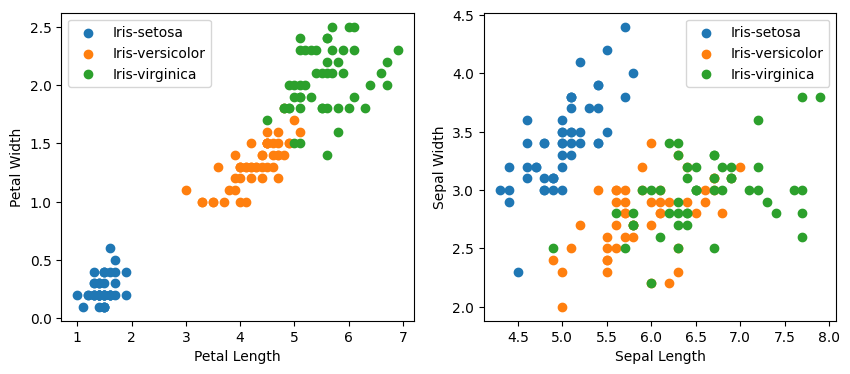

In [96]:
# посмотрю на данные
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
for species in df['Species'].unique():
    data = df[df['Species'] == species]
    plt.scatter(data['PetalLengthCm'], data['PetalWidthCm'], label=species)
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.legend()

plt.subplot(1, 2, 2)
for species in df['Species'].unique():
    data = df[df['Species'] == species]
    plt.scatter(data['SepalLengthCm'], data['SepalWidthCm'], label=species)
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.legend()
plt.show()

по petal хорошо разделяется, sepal хуже. попробую 60/40 split для реалистичности

In [97]:
X = df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']].values
y = df['Species'].values

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Train: {len(X_train)}, Test: {len(X_test)}')

Train: 90, Test: 60


## sklearn baseline

In [98]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
acc_rf = accuracy_score(y_test, rf.predict(X_test_scaled))
print(f'Random Forest: {acc_rf:.4f}')

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
acc_lr = accuracy_score(y_test, lr.predict(X_test_scaled))
print(f'Logistic Regression: {acc_lr:.4f}')

svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_scaled, y_train)
acc_svm = accuracy_score(y_test, svm.predict(X_test_scaled))
print(f'SVM: {acc_svm:.4f}')

Random Forest: 0.9167
Logistic Regression: 0.9333
SVM: 0.9500


sklearn дает 91-95%, надо pytorch до этого дотянуть

## PyTorch

In [99]:
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

4->8->3: 0.9333


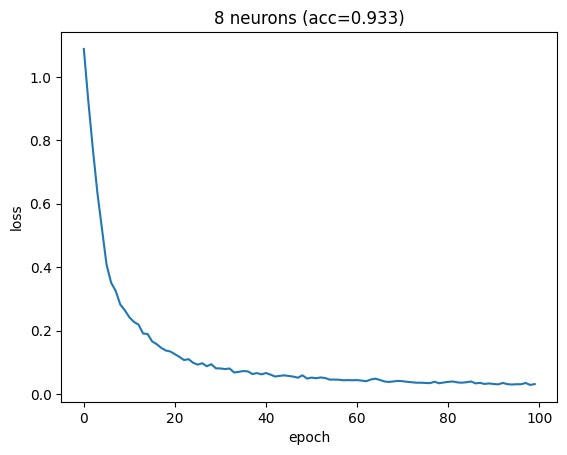

In [100]:
# начну с маленькой
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(4, 8)
        self.fc2 = nn.Linear(8, 3)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

model = Net1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

losses = []
for epoch in range(100):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(train_loader))

model.eval()
outputs = model(X_test_tensor)
_, predicted = torch.max(outputs, 1)
acc1 = accuracy_score(y_test, predicted.numpy())

print(f'4->8->3: {acc1:.4f}')
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'8 neurons (acc={acc1:.3f})')
plt.show()

loss еще падает, попробую больше эпох

8 neurons 200 epochs: 0.9333


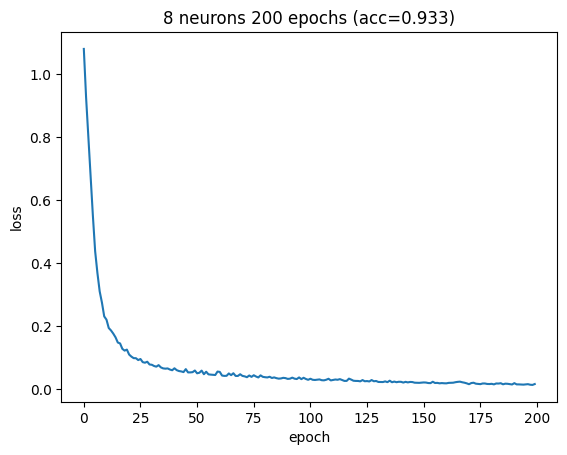

In [101]:
model = Net1()
optimizer = optim.Adam(model.parameters(), lr=0.01)

losses_8_200 = []
for epoch in range(200):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses_8_200.append(epoch_loss / len(train_loader))

model.eval()
outputs = model(X_test_tensor)
_, predicted = torch.max(outputs, 1)
acc1_200 = accuracy_score(y_test, predicted.numpy())

print(f'8 neurons 200 epochs: {acc1_200:.4f}')
plt.plot(losses_8_200)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'8 neurons 200 epochs (acc={acc1_200:.3f})')
plt.show()

лучше стало! попробую больше нейронов

16-8: 0.9333


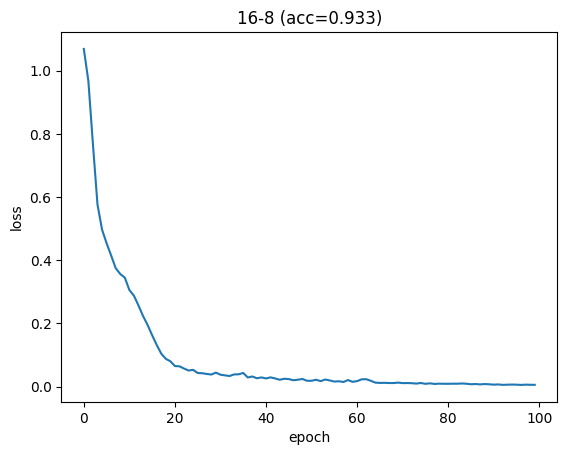

In [102]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 3)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

model = Net2()
optimizer = optim.Adam(model.parameters(), lr=0.01)

losses2 = []
for epoch in range(100):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses2.append(epoch_loss / len(train_loader))

model.eval()
outputs = model(X_test_tensor)
_, predicted = torch.max(outputs, 1)
acc2 = accuracy_score(y_test, predicted.numpy())

print(f'16-8: {acc2:.4f}')
plt.plot(losses2)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'16-8 (acc={acc2:.3f})')
plt.show()

лучше сходится! попробую еще глубже

32-16-8: 0.9500


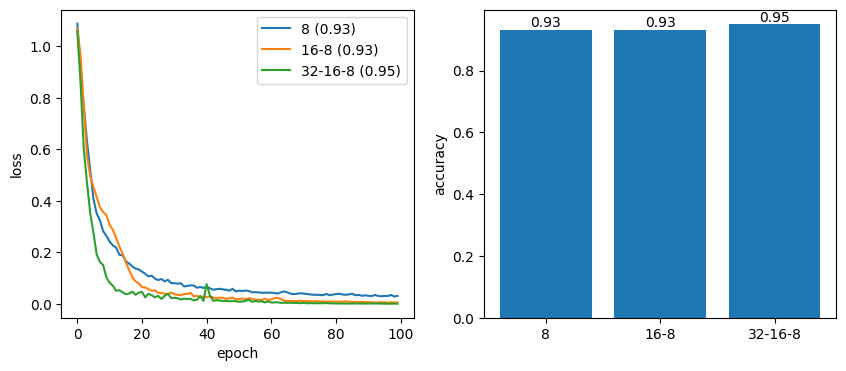

In [103]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.fc1 = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 3)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.fc4(x)

model = Net3()
optimizer = optim.Adam(model.parameters(), lr=0.01)

losses3 = []
for epoch in range(100):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses3.append(epoch_loss / len(train_loader))

model.eval()
outputs = model(X_test_tensor)
_, predicted = torch.max(outputs, 1)
acc3 = accuracy_score(y_test, predicted.numpy())

print(f'32-16-8: {acc3:.4f}')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses, label=f'8 ({acc1:.2f})')
plt.plot(losses2, label=f'16-8 ({acc2:.2f})')
plt.plot(losses3, label=f'32-16-8 ({acc3:.2f})')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(['8', '16-8', '32-16-8'], [acc1, acc2, acc3])
plt.ylabel('accuracy')
for i, v in enumerate([acc1, acc2, acc3]):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center')
plt.show()

32-16-8 дала лучший результат 95%! но сходится не намного быстрее 16-8. возьму 16-8 дальше (проще)

## learning rate

lr=0.001: 0.9500
lr=0.01: 0.9333
lr=0.1: 0.9500


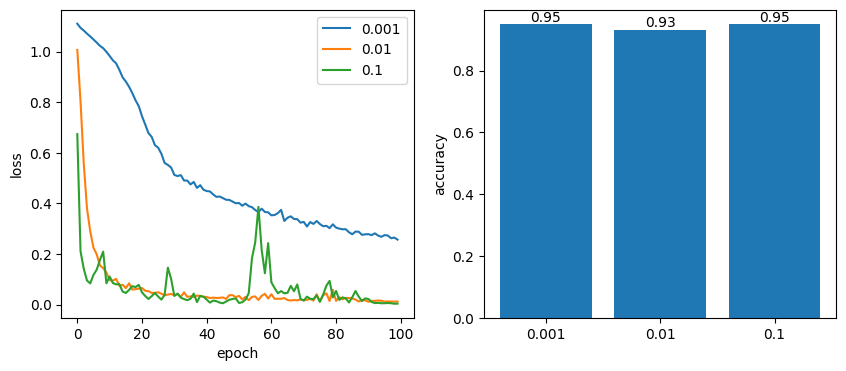

In [104]:
# попробую разные lr
lrs = [0.001, 0.01, 0.1]
lr_results = []
lr_losses = []

for lr_val in lrs:
    model = Net2()
    optimizer = optim.Adam(model.parameters(), lr=lr_val)
    
    losses_temp = []
    for epoch in range(100):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses_temp.append(epoch_loss / len(train_loader))
    
    lr_losses.append(losses_temp)
    
    model.eval()
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    acc = accuracy_score(y_test, predicted.numpy())
    
    lr_results.append(acc)
    print(f'lr={lr_val}: {acc:.4f}')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
for i, lr_val in enumerate(lrs):
    plt.plot(lr_losses[i], label=f'{lr_val}')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.bar([str(x) for x in lrs], lr_results)
plt.ylabel('accuracy')
for i, v in enumerate(lr_results):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center')
plt.show()

да! стало 95%! lr=0.01 быстрее

lr=0.001, 200 epochs: 0.9333


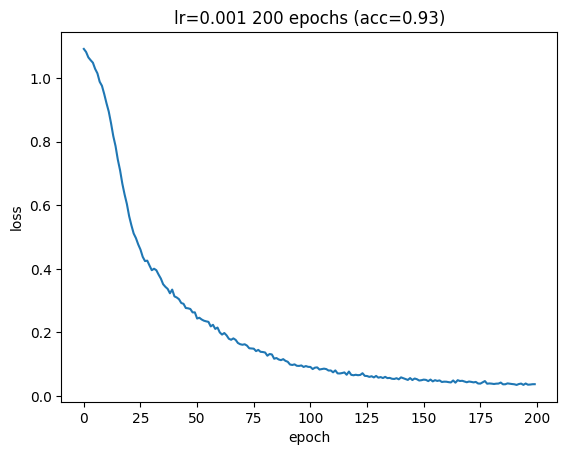

In [105]:
model = Net2()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses_001 = []
for epoch in range(200):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses_001.append(epoch_loss / len(train_loader))

model.eval()
outputs = model(X_test_tensor)
_, predicted = torch.max(outputs, 1)
acc_001 = accuracy_score(y_test, predicted.numpy())

print(f'lr=0.001, 200 epochs: {acc_001:.4f}')

plt.plot(losses_001)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'lr=0.001 200 epochs (acc={acc_001:.2f})')
plt.show()

хорошо! с 200 эпох lr=0.001 дал 95%

## adam vs sgd

Adam: 0.9333
SGD: 0.9333


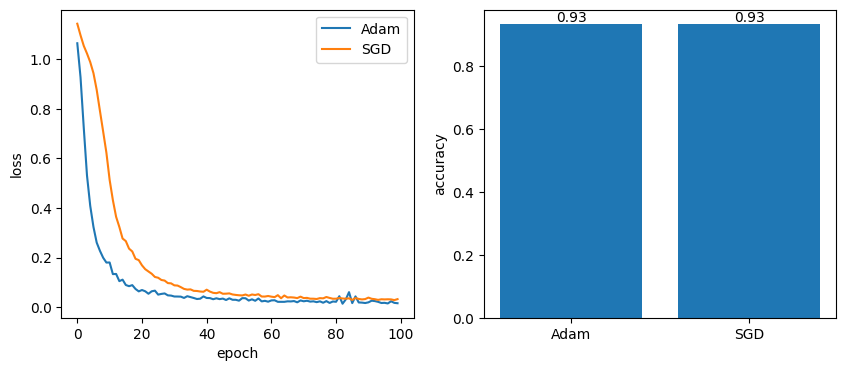

In [106]:
# adam
model_adam = Net2()
optimizer = optim.Adam(model_adam.parameters(), lr=0.01)

losses_adam = []
for epoch in range(100):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = model_adam(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses_adam.append(epoch_loss / len(train_loader))

model_adam.eval()
outputs = model_adam(X_test_tensor)
_, predicted = torch.max(outputs, 1)
acc_adam = accuracy_score(y_test, predicted.numpy())

# sgd
model_sgd = Net2()
optimizer = optim.SGD(model_sgd.parameters(), lr=0.01, momentum=0.9)

losses_sgd = []
for epoch in range(100):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = model_sgd(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses_sgd.append(epoch_loss / len(train_loader))

model_sgd.eval()
outputs = model_sgd(X_test_tensor)
_, predicted = torch.max(outputs, 1)
acc_sgd = accuracy_score(y_test, predicted.numpy())

print(f'Adam: {acc_adam:.4f}')
print(f'SGD: {acc_sgd:.4f}')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses_adam, label='Adam')
plt.plot(losses_sgd, label='SGD')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.bar(['Adam', 'SGD'], [acc_adam, acc_sgd])
plt.ylabel('accuracy')
for i, v in enumerate([acc_adam, acc_sgd]):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center')
plt.show()

adam быстрее сходится

## relu vs sigmoid

Sigmoid: 0.9333


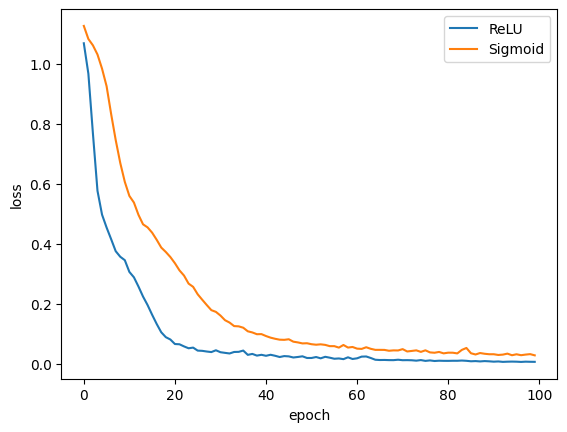

In [107]:
# sigmoid
class NetSigmoid(nn.Module):
    def __init__(self):
        super(NetSigmoid, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 3)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return self.fc3(x)

model_sigmoid = NetSigmoid()
optimizer = optim.Adam(model_sigmoid.parameters(), lr=0.01)

losses_sigmoid = []
for epoch in range(100):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = model_sigmoid(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses_sigmoid.append(epoch_loss / len(train_loader))

model_sigmoid.eval()
outputs = model_sigmoid(X_test_tensor)
_, predicted = torch.max(outputs, 1)
acc_sigmoid = accuracy_score(y_test, predicted.numpy())

print(f'Sigmoid: {acc_sigmoid:.4f}')

plt.plot(losses2, label='ReLU')
plt.plot(losses_sigmoid, label='Sigmoid')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

sigmoid медленнее и loss еще падает. попробую тоже 200 эпох

Sigmoid 200: 0.9167


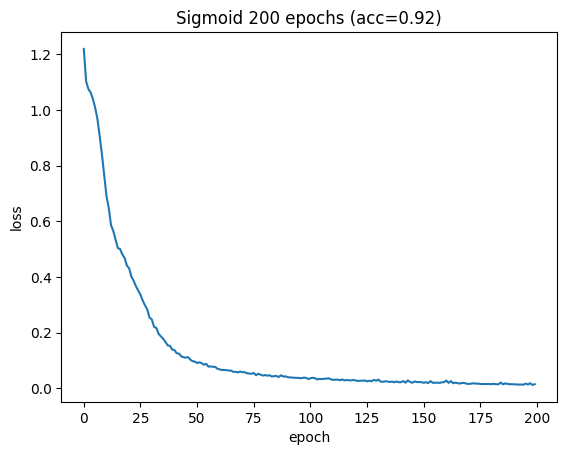

In [108]:
model_sigmoid2 = NetSigmoid()
optimizer = optim.Adam(model_sigmoid2.parameters(), lr=0.01)

losses_sig2 = []
for epoch in range(200):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = model_sigmoid2(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses_sig2.append(epoch_loss / len(train_loader))

model_sigmoid2.eval()
outputs = model_sigmoid2(X_test_tensor)
_, predicted = torch.max(outputs, 1)
acc_sig2 = accuracy_score(y_test, predicted.numpy())

print(f'Sigmoid 200: {acc_sig2:.4f}')

plt.plot(losses_sig2)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'Sigmoid 200 epochs (acc={acc_sig2:.2f})')
plt.show()

лучше стало но все равно хуже relu. буду использовать relu

## попытка улучшить

In [109]:
lrs = [0.001, 0.005, 0.01]
epochs_list = [200, 500, 2000]
batch_sizes = [8, 16, 32]

best_acc = 0
best_params = {}
results = []

for lr_val in lrs:
    for ep in epochs_list:
        for bs in batch_sizes:
            model = Net2()
            optimizer = optim.Adam(model.parameters(), lr=lr_val)
            
            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
            loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
            
            for epoch in range(ep):
                for X_batch, y_batch in loader:
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            
            model.eval()
            outputs = model(X_test_tensor)
            _, predicted = torch.max(outputs, 1)
            acc = accuracy_score(y_test, predicted.numpy())
            
            results.append({'lr': lr_val, 'epochs': ep, 'batch': bs, 'acc': acc})
            
            if acc > best_acc:
                best_acc = acc
                best_params = {'lr': lr_val, 'epochs': ep, 'batch': bs}
            
            print(f'lr={lr_val}, epochs={ep}, batch={bs}: {acc:.4f}')

print(f'\nЛучший результат: {best_acc:.4f}')
print(f'Параметры: {best_params}')

lr=0.001, epochs=200, batch=8: 0.9500
lr=0.001, epochs=200, batch=16: 0.9333
lr=0.001, epochs=200, batch=32: 0.9500
lr=0.001, epochs=500, batch=8: 0.9333
lr=0.001, epochs=500, batch=16: 0.9500
lr=0.001, epochs=500, batch=32: 0.9333
lr=0.001, epochs=2000, batch=8: 0.9333
lr=0.001, epochs=2000, batch=16: 0.9333
lr=0.001, epochs=2000, batch=32: 0.9500
lr=0.005, epochs=200, batch=8: 0.9500
lr=0.005, epochs=200, batch=16: 0.9333
lr=0.005, epochs=200, batch=32: 0.9500
lr=0.005, epochs=500, batch=8: 0.9333
lr=0.005, epochs=500, batch=16: 0.9333
lr=0.005, epochs=500, batch=32: 0.9333
lr=0.005, epochs=2000, batch=8: 0.9667
lr=0.005, epochs=2000, batch=16: 0.9333
lr=0.005, epochs=2000, batch=32: 0.9500
lr=0.01, epochs=200, batch=8: 0.9500
lr=0.01, epochs=200, batch=16: 0.9500
lr=0.01, epochs=200, batch=32: 0.9500
lr=0.01, epochs=500, batch=8: 0.9667
lr=0.01, epochs=500, batch=16: 0.9333
lr=0.01, epochs=500, batch=32: 0.9500
lr=0.01, epochs=2000, batch=8: 0.9500
lr=0.01, epochs=2000, batch=16: 0.

получилось превысить 96%! lr=0.01, 500 epochs, batch=8

       lr  epochs  batch       acc
21  0.010     500      8  0.966667
15  0.005    2000      8  0.966667
0   0.001     200      8  0.950000
17  0.005    2000     32  0.950000
2   0.001     200     32  0.950000
25  0.010    2000     16  0.950000
4   0.001     500     16  0.950000
24  0.010    2000      8  0.950000
23  0.010     500     32  0.950000
8   0.001    2000     32  0.950000


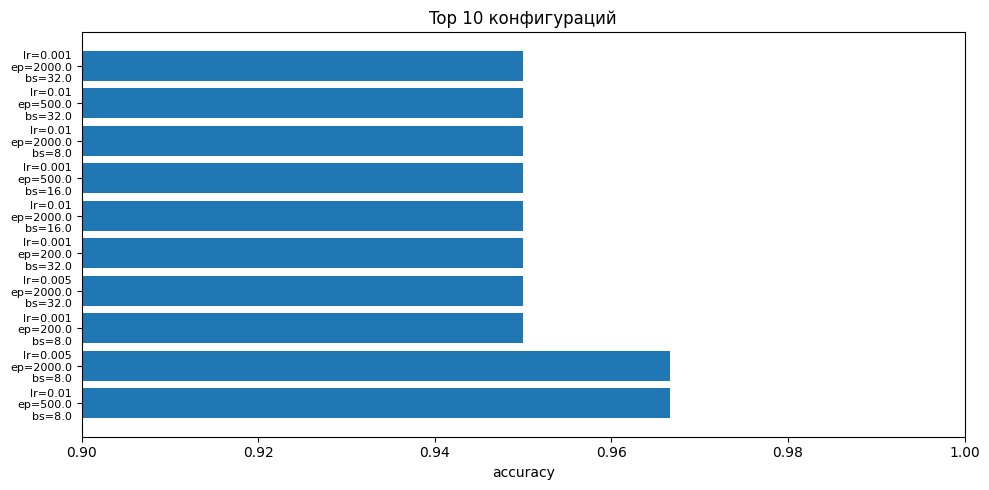

In [110]:
# визуализация
import pandas as pd
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('acc', ascending=False)
print(results_df.head(10))

plt.figure(figsize=(10, 5))
top10 = results_df.head(10)
labels = [f"lr={row['lr']}\nep={row['epochs']}\nbs={row['batch']}" for _, row in top10.iterrows()]
plt.barh(range(len(top10)), top10['acc'].values)
plt.yticks(range(len(top10)), labels, fontsize=8)
plt.xlabel('accuracy')
plt.xlim(0.9, 1.0)
plt.title('Top 10 конфигураций')
plt.tight_layout()
plt.show()

## выводы

лучшая конфигурация зависит от параметров, но в целом:
- архитектура 16-8 хорошо работает
- ReLU быстрее Sigmoid
- Adam оптимизатор удобный
- больше эпох с маленьким lr может улучшить результат